In [1]:
import pandas as pd
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from time import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

In [2]:
# encoder to assign numerical values to categorical variables
def label_encode(df):
    le = LabelEncoder()
    for col in df.columns:
        if df[col].dtype =='O':
            df[col]=le.fit_transform(df.loc[:,[col]])
    return df

In [3]:
start=time()

# Load passenger dataset

The passenger dataset describes each of 114132 passengers, their experience through screening, their final destination, and date and time data.

In [4]:
passengers_df=pd.read_csv('./Data/dat_P_sub_c.csv', index_col='Pass_ID')
print(len(passengers_df))
passengers_df.head()

114132


,valid_P_ID,Airfield,S2,Wait_Time,C_Start,C0,C_avg,Sch_Departure,Act_Departure,BFO_Dest_City,...,Day_of_Week,Month,Season,Year,WT_flag,S2_Sch_Flag,S2_Act_Flag,Sch_Act_Flag,Flight_ID,Delay_in_Seconds
Pass_ID,,,,,,,,,,,,,,,,,,,,,
5348206,1,AUC,2028-09-01 6:37,NaN,1,1,1.0,2028-09-01 8:06,2028-09-01 8:06,BORQUE,...,5 - FRI,09 - SEP,3 - SUMMER,2028,1,0,0,0,18095,0
5348209,1,AUC,2028-09-01 6:38,NaN,1,1,1.0,2028-09-01 8:06,2028-09-01 8:06,BORQUE,...,5 - FRI,09 - SEP,3 - SUMMER,2028,1,0,0,0,18095,0
5348216,1,AUC,2028-09-01 6:39,NaN,1,1,1.0,2028-09-01 8:06,2028-09-01 8:06,BORQUE,...,5 - FRI,09 - SEP,3 - SUMMER,2028,1,0,0,0,18095,0
5348224,1,AUC,2028-09-01 6:39,NaN,1,1,1.0,2028-09-01 8:06,2028-09-01 8:06,BORQUE,...,5 - FRI,09 - SEP,3 - SUMMER,2028,1,0,0,0,18095,0
5348225,1,AUC,2028-09-01 6:40,NaN,1,1,1.0,2028-09-01 8:06,2028-09-01 8:06,BORQUE,...,5 - FRI,09 - SEP,3 - SUMMER,2028,1,0,0,0,18095,0


## Add traffic indicator (for third prediction)

We will use the number of passengers scanned in the given hour as an indicator for traffic volume (used in third prediction attempt). For example, if a passenger was scanned at 2028-09-01 6:37, then the traffic volume is the number of passengers scanned between 2028-09-01 6:00 and 2028-09-01 7:00.

In [5]:
passengers_df['Hour']=[dt.split(':')[0] for dt in passengers_df.S2]
traffic_per_hour=passengers_df.groupby('Hour').count()['valid_P_ID']
passengers_df['Traffic_for_hour']=[traffic_per_hour[h] for h in passengers_df.Hour]
passengers_df

,valid_P_ID,Airfield,S2,Wait_Time,C_Start,C0,C_avg,Sch_Departure,Act_Departure,BFO_Dest_City,...,Season,Year,WT_flag,S2_Sch_Flag,S2_Act_Flag,Sch_Act_Flag,Flight_ID,Delay_in_Seconds,Hour,Traffic_for_hour
Pass_ID,,,,,,,,,,,,,,,,,,,,,
5348206,1,AUC,2028-09-01 6:37,NaN,1,1,1.0,2028-09-01 8:06,2028-09-01 8:06,BORQUE,...,3 - SUMMER,2028,1,0,0,0,18095,0,2028-09-01 6,40
5348209,1,AUC,2028-09-01 6:38,NaN,1,1,1.0,2028-09-01 8:06,2028-09-01 8:06,BORQUE,...,3 - SUMMER,2028,1,0,0,0,18095,0,2028-09-01 6,40
5348216,1,AUC,2028-09-01 6:39,NaN,1,1,1.0,2028-09-01 8:06,2028-09-01 8:06,BORQUE,...,3 - SUMMER,2028,1,0,0,0,18095,0,2028-09-01 6,40
5348224,1,AUC,2028-09-01 6:39,NaN,1,1,1.0,2028-09-01 8:06,2028-09-01 8:06,BORQUE,...,3 - SUMMER,2028,1,0,0,0,18095,0,2028-09-01 6,40
5348225,1,AUC,2028-09-01 6:40,NaN,1,1,1.0,2028-09-01 8:06,2028-09-01 8:06,BORQUE,...,3 - SUMMER,2028,1,0,0,0,18095,0,2028-09-01 6,40
5348226,1,AUC,2028-09-01 6:40,NaN,1,1,1.0,2028-09-01 8:06,2028-09-01 8:06,BORQUE,...,3 - SUMMER,2028,1,0,0,0,18095,0,2028-09-01 6,40
5348229,1,AUC,2028-09-01 6:41,NaN,1,1,1.0,2028-09-01 8:06,2028-09-01 8:06,BORQUE,...,3 - SUMMER,2028,1,0,0,0,18095,0,2028-09-01 6,40
5348239,1,AUC,2028-09-01 6:41,NaN,1,1,1.0,2028-09-01 8:06,2028-09-01 8:06,BORQUE,...,3 - SUMMER,2028,1,0,0,0,18095,0,2028-09-01 6,40
5348240,1,AUC,2028-09-01 6:42,NaN,1,1,1.0,2028-09-01 8:06,2028-09-01 8:06,BORQUE,...,3 - SUMMER,2028,1,0,0,0,18095,0,2028-09-01 6,40


In [6]:
passengers_df.dtypes

valid_P_ID                        int64
Airfield                         object
S2                               object
Wait_Time                       float64
C_Start                           int64
C0                                int64
C_avg                           float64
Sch_Departure                    object
Act_Departure                    object
BFO_Dest_City                    object
BFO_Destination_Country_Code     object
order                             int64
Departure_Date                   object
Time_of_Day                      object
Period_of_Week                   object
Day_of_Week                      object
Month                            object
Season                           object
Year                              int64
WT_flag                           int64
S2_Sch_Flag                       int64
S2_Act_Flag                       int64
Sch_Act_Flag                      int64
Flight_ID                         int64
Delay_in_Seconds                  int64


## Split into observations

Split by wait time

In [7]:
passengers_WT = passengers_df.query('Wait_Time == Wait_Time')
passengers_noWT = passengers_df.query('Wait_Time != Wait_Time')
len(passengers_WT), len(passengers_noWT)

(97261, 16871)

Split into train and test sets

In [8]:
train, test = train_test_split(passengers_WT, test_size=0.5)

## Set up the three predictions

We will not regress on the variables that are constant accross the entire dataset such as Airfiled and Year.
1. C0 and categorical variables
2. C0, C_Start and categorical variables
3. C0, C_Start, Traffic and categorical variables

In [10]:
cols=[]
cols.append(['C0', 'Departure_Date','Time_of_Day', 'Period_of_Week', 'Day_of_Week', 'Month', 'Season', 
             'S2_Sch_Flag', 'S2_Act_Flag', 'Sch_Act_Flag'])
cols.append(['C0', 'C_Start','Departure_Date','Time_of_Day', 'Period_of_Week', 'Day_of_Week', 'Month', 'Season', 
             'S2_Sch_Flag', 'S2_Act_Flag', 'Sch_Act_Flag'])
cols.append(['C0', 'C_Start','Traffic_for_hour', 'Departure_Date','Time_of_Day', 'Period_of_Week', 'Day_of_Week', 'Month', 'Season', 
             'S2_Sch_Flag', 'S2_Act_Flag', 'Sch_Act_Flag'])

# Initialise sklearn models

These models are available as part of sci-kit learn and can take on different parameters.

In [11]:
lm=LinearRegression()
rt=DecisionTreeRegressor()
sv=LinearSVR()
rf=RandomForestRegressor()

## Brief hyperparameter search
Can also use sklearn.model_selection hyper parameter optimisers.

In [18]:
X_train=pd.get_dummies(train.loc[:,cols[0]])
y_train=train.Wait_Time
X_test=pd.get_dummies(test.loc[:,cols[0]])
y_test=test.Wait_Time

### Linear Regression
Not many parameters. Keep default.

### Decision Tree

Search on maximum depth. Trees that are too deep can lead to overfitting.

In [42]:
rt

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

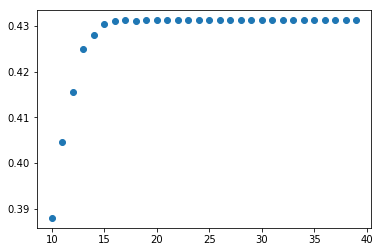

In [78]:
depths=range(10,40)
plt.plot(depths, 
         [r2_score(y_test,
                   DecisionTreeRegressor(max_depth=d).fit(X_train,y_train).predict(X_test)) 
          for d in depths],
         'o')

Keep default None

### SVM

Using a linear kernel for efficiency. Search on C (error penalty), epsilon (loss parameter) and max_iter.

In [56]:
sv

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)

In [57]:
for C in [1,10,100]:
    for epsilon in [0,0.1]:
        for max_iter in [1000, 2000]:
            model=LinearSVR(C=C, epsilon=epsilon, max_iter=max_iter)
            predicted=model.fit(X_train,y_train).predict(X_test)
            print(model,r2_score(y_test,predicted))

LinearSVR(C=1, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0) -1.4290392849
LinearSVR(C=1, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=2000,
     random_state=None, tol=0.0001, verbose=0) -0.0314570007985
LinearSVR(C=10, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0) 0.0216881724761
LinearSVR(C=10, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=2000,
     random_state=None, tol=0.0001, verbose=0) 0.163363826387
LinearSVR(C=100, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0) -1.35287880561
LinearSVR(C=100, dual=True, epsilo

In [ ]:
train_svm, test_svm = train_test_split(passengers_WT, test_size=0.1)
X_train_svm=pd.get_dummies(train_svm.loc[:,cols[0]])
y_train_svm=train_svm.Wait_Time
X_test_svm=pd.get_dummies(test_svm.loc[:,cols[0]])
y_test_svm=test_svm.Wait_Time


for max_iter in [4000, 6000, 8000, 10000]:
    model=LinearSVR(C=1, max_iter=max_iter)
    predicted=model.fit(X_train_svm,y_train_svm).predict(X_test_svm)
    print(model,r2_score(y_test_svm,predicted))

LinearSVR(C=1, dual=True, epsilon=0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=4000,
     random_state=None, tol=0.0001, verbose=0) 0.184255946967
LinearSVR(C=1, dual=True, epsilon=0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=6000,
     random_state=None, tol=0.0001, verbose=0) 0.184508695687
LinearSVR(C=1, dual=True, epsilon=0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=8000,
     random_state=None, tol=0.0001, verbose=0) 0.184173712445
LinearSVR(C=1, dual=True, epsilon=0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
     random_state=None, tol=0.0001, verbose=0) 0.184354185476
LinearSVR(C=1, dual=True, epsilon=0.1, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=4000,
     random_state=None, tol=0.0001, verbose=0) 0.187722837061
LinearSVR(C=1, dual=True, epsilon=0.1, fit_inte

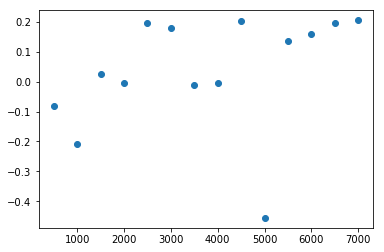

In [87]:
#takes some time...

'''iters=[500*i for i in range(1,15)]
plt.plot(iters, 
         [r2_score(y_test,
                   LinearSVR(max_iter=i).fit(X_train,y_train).predict(X_test)) 
          for i in iters],
         'o')'''

Increase max_iter but keep default C=1. Caution: Larger max_iter means longer running time. Adjust accounding to your resources.

In [58]:
sv=LinearSVR(C=1, max_iter=2000)

### Random Forest

Using a linear kernel for efficiency. Search on max_depth.

In [59]:
rf

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

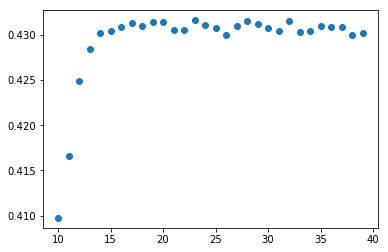

In [77]:
depths=range(10,40)
plt.plot(depths, 
         [r2_score(y_test,
                   RandomForestRegressor(max_depth=d).fit(X_train,y_train).predict(X_test)) 
          for d in depths],
         'o')

Keep default None

# Run predictions
For each attempt we will fit each of the 4 models to the dummied training set and cross-validate it with the test set.

Measures of goodness of fit include $R^2$, explained variance and -MSE. A higher score for each of these metrics is optimal.

In [ ]:
scoring=['r2','explained_variance','neg_mean_squared_error']

## 1st attempt

In [106]:
X_train=pd.get_dummies(train.loc[:,cols[0]])
y_train=train.Wait_Time
X_test=pd.get_dummies(test.loc[:,cols[0]])
y_test=test.Wait_Time

for i,model in enumerate([lm, rt, sv, rf]):
    print('Model: ' + str(model).split('(')[0])
    
    predicted=model.fit(X_train,y_train).predict(X_test)  #regular train vs test
    try:
        print('Feature importances: ' + str(dict(zip(cols[0],model.feature_importances_))))
    except:
        print('Coefficients: ' + str(dict(zip(cols[0],model.coef_))))
    print('R2 = ' + str(r2_score(y_test,predicted)))
    
    cross_validation=cross_validate(model,X_test,y_test,scoring=scoring) #3-fold cross validation
    [print("{}: {}".format(k,v)) for k,v in cross_validation.items()]
    
    print()

Model: LinearRegression
Coefficients: {'C0': 2.8697942614426455, 'Departure_Date': 0.019196940934304088, 'Time_of_Day': -1.1678499442842125, 'Period_of_Week': -1.9945101053269545, 'Day_of_Week': 0.43777302638936189, 'Month': -0.79241094103317, 'Season': 0.32105755972218802, 'S2_Sch_Flag': -0.24358609659842273, 'S2_Act_Flag': 3.3089594832950495, 'Sch_Act_Flag': 0.024819122519074401}
R2 = 0.196008725369
fit_time: [ 0.00959301  0.01989794  0.0140779 ]
score_time: [ 0.00438309  0.01167917  0.00627804]
test_r2: [ 0.19373414  0.19241601  0.20340203]
train_r2: [ 0.1984318   0.19929922  0.19388544]
test_explained_variance: [ 0.1937492   0.19257327  0.20348611]
train_explained_variance: [ 0.1984318   0.19929922  0.19388544]
test_neg_mean_squared_error: [-16.69691012 -17.48440532 -16.08593672]
train_neg_mean_squared_error: [-16.77125816 -16.3752733  -17.07382803]

Model: DecisionTreeRegressor
Feature importances: {'C0': 0.32280714246551895, 'Departure_Date': 0.34767805247284728, 'Time_of_Day': 0

The first prediction is ok. The SVM is not very good and the linear model is only slightly better. I would say the decision tree and random forest perform the best. Accross all models, C0 is one of the most influential factors. Other important factors include date, day/period of week.

## 2nd attempt
Adding C_Start

In [114]:
X_train=pd.get_dummies(train.loc[:,cols[1]])
y_train=train.Wait_Time
X_test=pd.get_dummies(test.loc[:,cols[1]])
y_test=test.Wait_Time

for i,model in enumerate([lm, rt, sv, rf]):
    print('Model: ' + str(model).split('(')[0])
    
    predicted=model.fit(X_train,y_train).predict(X_test)  #regular train vs test
    try:
        print('Feature importances: ' + str(dict(zip(cols[1],model.feature_importances_))))
    except:
        print('Coefficients: ' + str(dict(zip(cols[1],model.coef_))))
    print('R2 = ' + str(r2_score(y_test,predicted)))
    
    cross_validation=cross_validate(model,X_test,y_test,scoring=scoring) #3-fold cross validation
    [print("{}: {}".format(k,v)) for k,v in cross_validation.items() ]
    
    print()

Model: LinearRegression
Coefficients: {'C0': 3.574616553309883, 'C_Start': -0.82275389179485181, 'Departure_Date': 0.019513053070399529, 'Time_of_Day': -1.1793404377046661, 'Period_of_Week': -2.0034370355278672, 'Day_of_Week': 0.43947577376214275, 'Month': -0.79312901090384536, 'Season': 0.31666942529966141, 'S2_Sch_Flag': -0.23147252775836694, 'S2_Act_Flag': 3.3254279173090211, 'Sch_Act_Flag': 0.018299599897808168}
R2 = 0.198000314723
fit_time: [ 0.00805092  0.00787592  0.00808811]
score_time: [ 0.004565    0.00328898  0.00346327]
test_r2: [ 0.19676705  0.19276048  0.20525512]
train_r2: [ 0.19973519  0.20199871  0.19588143]
test_explained_variance: [ 0.19678492  0.19292411  0.20533538]
train_explained_variance: [ 0.19973519  0.20199871  0.19588143]
test_neg_mean_squared_error: [-16.63410168 -17.47694764 -16.04851676]
train_neg_mean_squared_error: [-16.74398733 -16.32006539 -17.03155215]

Model: DecisionTreeRegressor
Feature importances: {'C0': 0.26898948058128525, 'C_Start': 0.1408119

Adding the imputed C_Start improved the models slightly, except for the SVM. 

## 3rd attempt
Adding traffic indicator.

In [113]:
X_train=pd.get_dummies(train.loc[:,cols[2]])
y_train=train.Wait_Time
X_test=pd.get_dummies(test.loc[:,cols[2]])
y_test=test.Wait_Time

for i,model in enumerate([lm, rt, sv, rf]):
    print('Model: ' + str(model).split('(')[0])
    
    predicted=model.fit(X_train,y_train).predict(X_test)  #regular train vs test
    try:
        print('Feature importances: ' + str(dict(zip(cols[2],model.feature_importances_))))
    except:
        print('Coefficients: ' + str(dict(zip(cols[2],model.coef_)))) 
    print('R2 = ' + str(r2_score(y_test,predicted)))
    
    cross_validation=cross_validate(model,X_test,y_test,scoring=scoring) #3-fold cross validation
    [print("{}: {}".format(k,v)) for k,v in cross_validation.items() ]
    
    print()

Model: LinearRegression
Coefficients: {'C0': 3.0311801618032415, 'C_Start': -1.5796250897315183, 'Traffic_for_hour': 0.02717856861722337, 'Departure_Date': 0.012811847408689125, 'Time_of_Day': -1.1454454507060388, 'Period_of_Week': -1.5932700019308035, 'Day_of_Week': 0.32547965914303378, 'Month': -0.62606920168887203, 'Season': 0.31568606506955343, 'S2_Sch_Flag': 0.028616221255076041, 'S2_Act_Flag': 2.8603138489193833, 'Sch_Act_Flag': -0.38309405404275465}
R2 = 0.233071802151
fit_time: [ 0.01014876  0.00928497  0.00926995]
score_time: [ 0.0047822   0.00392103  0.00435686]
test_r2: [ 0.23311572  0.23033389  0.23592133]
train_r2: [ 0.2340401   0.23553081  0.23282249]
test_explained_variance: [ 0.23315385  0.23048165  0.23595931]
train_explained_variance: [ 0.2340401   0.23553081  0.23282249]
test_neg_mean_squared_error: [-15.8813593  -16.66347333 -15.42926497]
train_neg_mean_squared_error: [-16.02622364 -15.63429464 -16.2491258 ]

Model: DecisionTreeRegressor
Feature importances: {'C0': 

From looking at the feature importances and the validation metrics, we see the addition of the traffic indicator made a significant improvment to the tree and forest models.

## Summary Plots

We will plot all three predictions and all four models together. Each row of plots corresponds to one prediction (1st, 2nd, 3rd) and each column represents each of the four models. We plot the target (Wait_Time) predicted by each model (trained on the training set) against the actual target for the test set. The $R^2$ coefficient is displayed below each plot.

### Summarize prediction on dummied variables
Sci-kit learn regressors require numerical variables, we therefore encode categorical variables. We will encode the data using dummy variables. This binarises the categorical columns by adding a column for each possible categorical value. This adds to the memory but keeps categorical variables unordered.

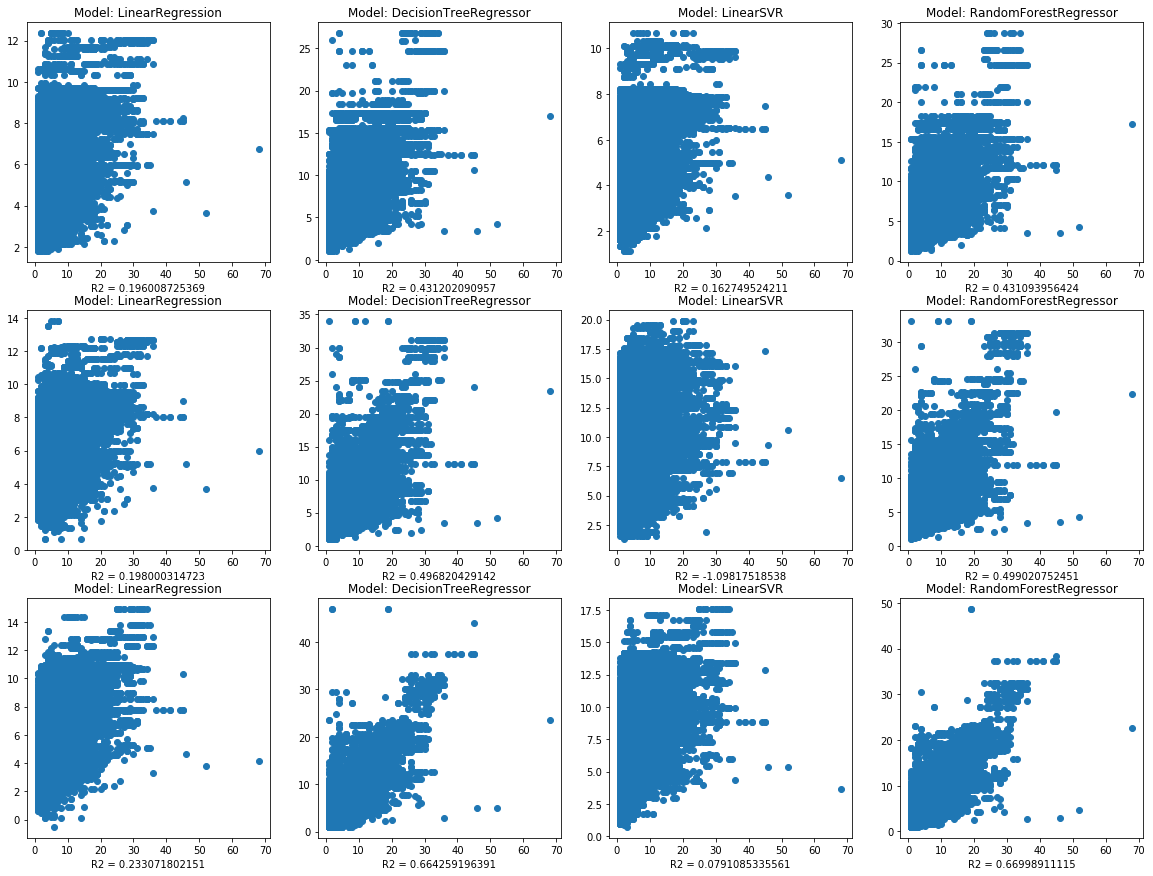

In [115]:
plt.subplots(figsize=(20,15))

for k in range(3):
    X_train=pd.get_dummies(train.loc[:,cols[k]])
    y_train=train.Wait_Time
    X_test=pd.get_dummies(test.loc[:,cols[k]])
    y_test=test.Wait_Time
    for i,model in enumerate([lm, rt, sv, rf]):
        plt.subplot(3,4,4*k+i+1)
        predicted=model.fit(X_train,y_train).predict(X_test)
        plt.plot(y_test,predicted, 'o')
        plt.title('Model: ' + str(model).split('(')[0])
        plt.xlabel('R2 = ' + str(r2_score(y_test,predicted)))


### Summarise predictions on encoded variables
An alternative encoding is to use LabelEncoder. This assigns numerical values to each categorical value. Keeps shape of dataframe but now categorical variables have order.

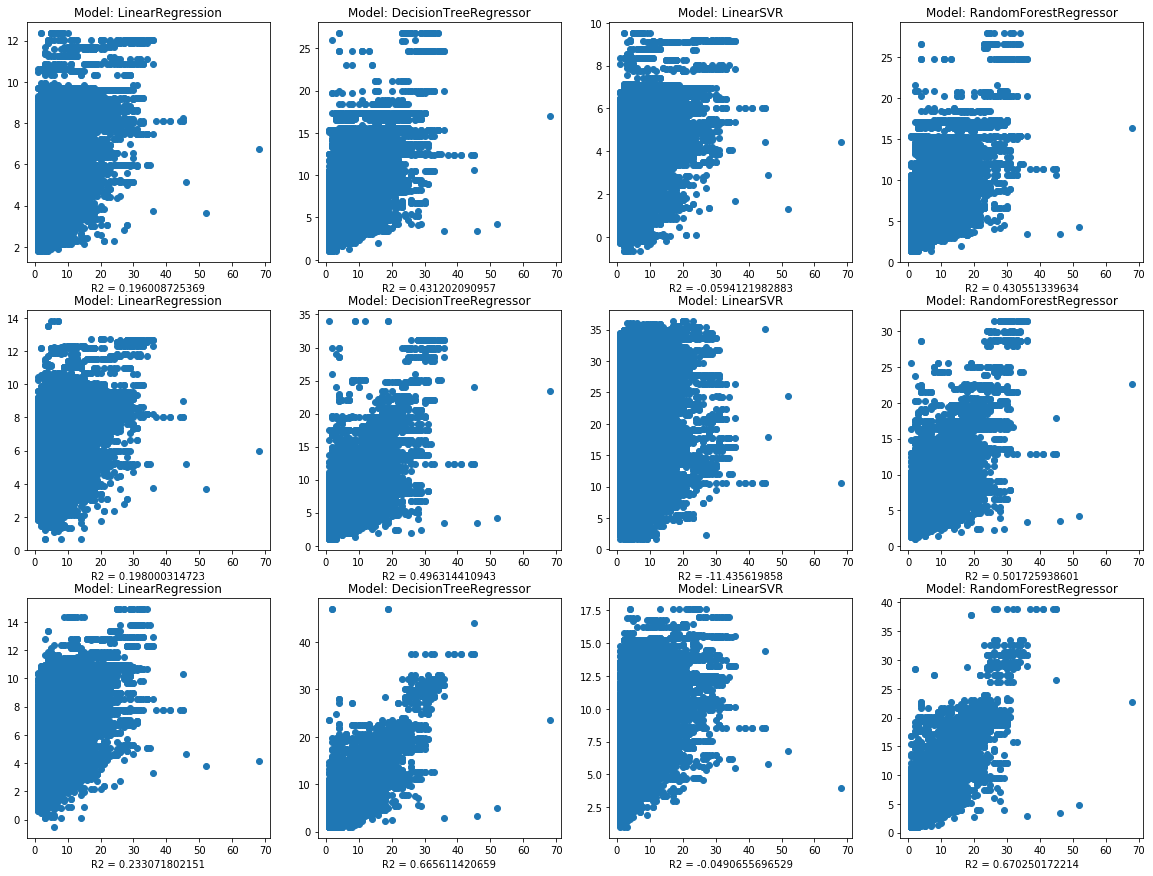

In [116]:
plt.subplots(figsize=(20,15))
encoded_train=label_encode(train)
encoded_test=label_encode(test)

for k in range(3):
    X_train=encoded_train.loc[:,cols[k]]
    y_train=train.Wait_Time
    X_test=encoded_test.loc[:,cols[k]]
    y_test=test.Wait_Time
    for i,model in enumerate([lm, rt, sv, rf]):
        plt.subplot(3,4,4*k+i+1)
        predicted=model.fit(X_train,y_train).predict(X_test)
        plt.plot(y_test,predicted, 'o')
        plt.title('Model: ' + str(model).split('(')[0])
        plt.xlabel('R2 = ' + str(r2_score(y_test,predicted)))


## Discussion

Both encodings gave similar results.

Except in the case of the support vector machine, adding variables improved our model. The effect of the addition of factors to the SVM varied between runs. Out of the four algorithms, the trees and forests performed the best. I would therefore be inclined to use a decision tree as it is more simple and we don't gain much from a random forest.

Using dummy variables, we could also simplify the model by ommiting the period of week and season since they are captured in the day of week and month (mostly, given seasons change on the 21st of March, June, September and December).

# Predictions

We will use the decision tree model to estimate the unknown wait times. Here, we are assuming that the subset of observations with wait times is not drastically different from the one without.

In [27]:
X_train=pd.get_dummies(train.loc[:,cols[2]])
y_train=train.Wait_Time
X=pd.get_dummies(passengers_noWT.loc[:,cols[2]])

In [31]:
y_pred=rt.fit(X_train,y_train).predict(X)
passengers_noWT['Wait_Time']=y_pred
passengers_noWT.head()

/Users/ionabuchanan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,valid_P_ID,Airfield,S2,Wait_Time,C_Start,C0,C_avg,Sch_Departure,Act_Departure,BFO_Dest_City,...,Season,Year,WT_flag,S2_Sch_Flag,S2_Act_Flag,Sch_Act_Flag,Flight_ID,Delay_in_Seconds,Hour,Traffic_for_hour
Pass_ID,,,,,,,,,,,,,,,,,,,,,
5348206,1,AUC,2028-09-01 6:37,3.0,1,1,1.0,2028-09-01 8:06,2028-09-01 8:06,BORQUE,...,3 - SUMMER,2028,1,0,0,0,18095,0,2028-09-01 6,40
5348209,1,AUC,2028-09-01 6:38,3.0,1,1,1.0,2028-09-01 8:06,2028-09-01 8:06,BORQUE,...,3 - SUMMER,2028,1,0,0,0,18095,0,2028-09-01 6,40
5348216,1,AUC,2028-09-01 6:39,3.0,1,1,1.0,2028-09-01 8:06,2028-09-01 8:06,BORQUE,...,3 - SUMMER,2028,1,0,0,0,18095,0,2028-09-01 6,40
5348224,1,AUC,2028-09-01 6:39,3.0,1,1,1.0,2028-09-01 8:06,2028-09-01 8:06,BORQUE,...,3 - SUMMER,2028,1,0,0,0,18095,0,2028-09-01 6,40
5348225,1,AUC,2028-09-01 6:40,3.0,1,1,1.0,2028-09-01 8:06,2028-09-01 8:06,BORQUE,...,3 - SUMMER,2028,1,0,0,0,18095,0,2028-09-01 6,40


In [33]:
passengers_noWT['Wait_Time'].describe()

count    16871.000000
mean         6.700324
std          5.987795
min          1.000000
25%          3.000000
50%          4.111111
75%          8.000000
max         46.000000
Name: Wait_Time, dtype: float64

In [34]:
passengers_WT['Wait_Time'].describe()

count    97261.000000
mean         5.409095
std          4.561707
min          1.000000
25%          3.000000
50%          4.000000
75%          7.000000
max         75.000000
Name: Wait_Time, dtype: float64

From looking at the distribution of predicted wait times compared to the actual ones that are included in the dataset, we see that the model did not make up any crazy predictions. However, since we don't have the actual wait-times for these new predictions, we can't really say much.

# Additional Content
Other factors that might improve our prediction include:
* Size of flight (although this may be captured by the traffic indicator). This can be found by cross-referencing the flight dataset
* Airfield and the wait-times and maximum number of servers for the airfield (if we were considering multiple airfields). 
* Holiday (It is quite common to experience longer wait times on holidays (Christmas, New Years, long weekends) and days where there are changes in schedule). Given a list of statuatory holidays for Boralia and other countries, observations could receive a "holiday" tag. But then again, designated holidays are not constant across all countries.
* Weather (This one is tricky to collect but may impact the wait-times)

In [ ]:
print("This notebook ran in {} seconds".format(time()-start))